# Milestone Project 1 : Food Vision Big(TM)

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'
import tensorflow as tf
# if tf.__version__ != "2.9.0":
#   !pip install -U -q tensorflow==2.9.0
#   !pip install -q tensorflow_datasets==4.8.2
#   !pip install -q protobuf==3.19.6
#   !pip install -q tensorflow_metadata==1.12.0
#   # import os
#   # os._exit(00)
print(tf.__version__)
from tensorflow.keras import mixed_precision
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
2.14.0-dev20230730
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [2]:
gpu=tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

In [3]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


In [4]:
! nvidia-smi

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Dec  4 01:38:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0              15W /  60W |    717MiB /  4096MiB |      0%      Default |
|                              

In [5]:
! nvidia-smi -L

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-dfaf2dbb-aec7-1a43-9749-df5dc8fdb316)


# Use Tensorflow Datasets

In [6]:
import tensorflow_datasets as tdfs
dataset_list = tdfs.list_builders()
print("food101" in dataset_list)

True


In [7]:
# Load the data
(train_data,test_data), ds_info = tdfs.load(name="food101",
                                            split=["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

In [8]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Features in Food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# take one sample of train_data
train_one_sample = train_data.take(1)

# Exploring the Food101 data from TensorFlow Datasets
Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the .take() method) and explore it.

In [11]:
# What does one sample of training data look like
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about training sample
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class(tensor form): {label},
  Class name(str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class(tensor form): 81,
  Class name(str form): ramen
  


In [13]:
#How does image look like:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[242, 254, 252],
        [241, 253, 251],
        [240, 252, 250],
        ...,
        [241, 211, 101],
        [242, 212, 102],
        [245, 215, 105]],

       [[240, 252, 250],
        [240, 252, 250],
        [239, 251, 249],
        ...,
        [245, 215, 105],
        [242, 212, 102],
        [240, 210, 100]],

       [[238, 250, 248],
        [238, 250, 248],
        [238, 250, 248],
        ...,
        [250, 218, 107],
        [243, 211, 100],
        [238, 206,  95]],

       ...,

       [[ 82,  81,  77],
        [ 83,  82,  78],
        [ 82,  81,  77],
        ...,
        [126, 128, 127],
        [135, 137, 136],
        [139, 141, 140]],

       [[ 82,  79,  74],
        [ 82,  79,  74],
        [ 81,  78,  73],
        ...,
        [209, 209, 209],
        [217, 217, 217],
        [215, 215, 215]],

       [[ 78,  75,  70],
        [ 77,  74,  69],
        [ 76,  73,  68],
        ...,
        [187, 187, 18

In [14]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

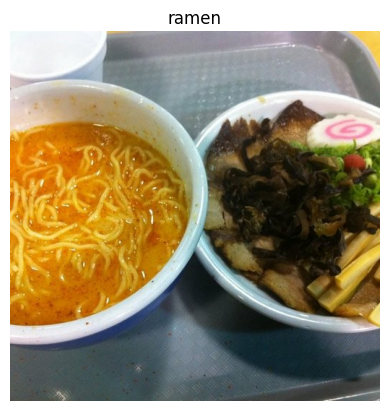

In [15]:
### Plot an image from tensorflow datasets
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False)

## Create preprocessing functions for our data

What we know about the data:
* It is in `uint8` datatype
* Image is not scaled
* Different sized images/tensors

What we know model prefers:
* Data in `float32` dtype
* For batches, tf likes all of tensors within a batch to be of same size
* Scaled (values between 0 and 1)



In [16]:
image,label

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[242, 254, 252],
         [241, 253, 251],
         [240, 252, 250],
         ...,
         [241, 211, 101],
         [242, 212, 102],
         [245, 215, 105]],
 
        [[240, 252, 250],
         [240, 252, 250],
         [239, 251, 249],
         ...,
         [245, 215, 105],
         [242, 212, 102],
         [240, 210, 100]],
 
        [[238, 250, 248],
         [238, 250, 248],
         [238, 250, 248],
         ...,
         [250, 218, 107],
         [243, 211, 100],
         [238, 206,  95]],
 
        ...,
 
        [[ 82,  81,  77],
         [ 83,  82,  78],
         [ 82,  81,  77],
         ...,
         [126, 128, 127],
         [135, 137, 136],
         [139, 141, 140]],
 
        [[ 82,  79,  74],
         [ 82,  79,  74],
         [ 81,  78,  73],
         ...,
         [209, 209, 209],
         [217, 217, 217],
         [215, 215, 215]],
 
        [[ 78,  75,  70],
         [ 77,  74,  69],
         [ 76,

In [17]:
# Use efficient net , no need to rescale, only need to reshape and cast the dtype
def preprocess_img(image,label,image_shape=48):
  image = tf.image.resize(image,[image_shape,image_shape])
  # image=image/255.
  return tf.cast(image,dtype=tf.float32), label

In [18]:
# Preprocess single sample
preprocessed_img1 = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}...,\nDtype: {image.dtype}\n\n")
print(f"Image after preprocessing:\n {preprocessed_img1[:2]}...,\nShape: {preprocessed_img1.shape}...,\nDtype: {preprocessed_img1.dtype}")

Image before preprocessing:
 [[[242 254 252]
  [241 253 251]
  [240 252 250]
  ...
  [241 211 101]
  [242 212 102]
  [245 215 105]]

 [[240 252 250]
  [240 252 250]
  [239 251 249]
  ...
  [245 215 105]
  [242 212 102]
  [240 210 100]]]...,
Shape: (512, 512, 3)...,
Dtype: <dtype: 'uint8'>


Image after preprocessing:
 [[[241.69444  251.69444  250.69444 ]
  [241.       249.5      250.5     ]
  [239.       244.       248.      ]
  [240.       245.       249.      ]
  [240.       244.       248.5     ]
  [243.83333  246.83333  251.83333 ]
  [245.83333  246.83333  250.83333 ]
  [244.       246.5      250.      ]
  [242.97223  246.97223  249.97223 ]
  [242.69446  245.69446  250.69446 ]
  [245.58333  249.08333  253.08333 ]
  [242.1389   246.1389   249.1389  ]
  [225.08308  227.08307  223.61082 ]
  [159.25     153.       152.5     ]
  [155.83333  151.83333  158.44446 ]
  [157.69446  157.44447  158.47224 ]
  [155.16667  156.83333  162.66667 ]
  [158.83333  157.83333  163.83333 ]
  [154.02779  

Batch input data

In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Creating model callbacks

1. Create Tensorboard callback
2. ModelCheckpoint callback

In [21]:
from helper_functions import create_tensorboard_callback

checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

### Set up mixed precission training

In [22]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [23]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [24]:
# Build feature extraction model
# mixed_precision.set_global_policy("float32")  # Set it to mixed_float16 in tf.__version__==2.4.1
input_shape=(48,48,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=input_shape)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation(tf.keras.activations.softmax,dtype=tf.float32)(x)

model=tf.keras.Model(inputs,outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

# Fit the model

In [25]:
history_101_feature_extract = model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[model_checkpoint])

Epoch 1/5
4735/4735 [==============================] - 43s 8ms/step - loss: 3.7147 - accuracy: 0.1626 - val_loss: 3.3390 - val_accuracy: 0.2105
Epoch 2/5
4735/4735 [==============================] - 39s 8ms/step - loss: 3.3036 - accuracy: 0.2256 - val_loss: 3.1880 - val_accuracy: 0.2450
Epoch 3/5
4735/4735 [==============================] - 39s 8ms/step - loss: 3.1701 - accuracy: 0.2504 - val_loss: 3.1420 - val_accuracy: 0.2508
Epoch 4/5
4735/4735 [==============================] - 41s 9ms/step - loss: 3.0833 - accuracy: 0.2681 - val_loss: 3.1260 - val_accuracy: 0.2540
Epoch 5/5
4735/4735 [==============================] - 41s 9ms/step - loss: 3.0186 - accuracy: 0.2782 - val_loss: 3.1244 - val_accuracy: 0.2609


In [26]:
#Evaluate
result = model.evaluate(test_data)

1579/1579 [==============================] - 20s 13ms/step - loss: 3.1210 - accuracy: 0.2593


In [27]:
for i,layers in enumerate(model.layers):
  print(i,layers.name)

0 input_2
1 efficientnetb0
2 global_average_pooling2d
3 dense
4 activation


In [28]:
for i,layer in enumerate(model.layers[1].layers):
  print(i,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [29]:
model.layers[1].trainable=True
for layer in model.layers[1].layers[:-15]:
  layer.trainable=False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 1037589 (3

In [30]:
history_101_fine_tune = model.fit(train_data,
                                  epochs=10,
                                  initial_epoch=history_101_feature_extract.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  steps_per_epoch=len(train_data))

Epoch 5/10
4735/4735 [==============================] - 53s 10ms/step - loss: 2.8290 - accuracy: 0.3160 - val_loss: 2.9744 - val_accuracy: 0.2895
Epoch 6/10
4735/4735 [==============================] - 47s 10ms/step - loss: 2.6284 - accuracy: 0.3534 - val_loss: 2.9943 - val_accuracy: 0.2810
Epoch 7/10
4735/4735 [==============================] - 50s 10ms/step - loss: 2.4627 - accuracy: 0.3870 - val_loss: 3.0031 - val_accuracy: 0.2963
Epoch 8/10
4735/4735 [==============================] - 50s 10ms/step - loss: 2.3012 - accuracy: 0.4221 - val_loss: 3.0439 - val_accuracy: 0.2934
Epoch 9/10
4735/4735 [==============================] - 50s 11ms/step - loss: 2.1440 - accuracy: 0.4588 - val_loss: 3.1231 - val_accuracy: 0.2873
Epoch 10/10
4735/4735 [==============================] - 50s 11ms/step - loss: 1.9832 - accuracy: 0.4959 - val_loss: 3.2439 - val_accuracy: 0.2757


In [31]:
result_fine_tune = model.evaluate(test_data)

1579/1579 [==============================] - 20s 13ms/step - loss: 3.2669 - accuracy: 0.2770


# Challenge - Milestone Project

In [ ]:
## Load in a gs model
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
model_challenge = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
model_challenge.summary()

In [ ]:
for i,layer in enumerate(model_challenge.layers):
  print(i,layer.name,layer.trainable)

In [ ]:
result1_challenge = model_challenge.evaluate(test_data)

In [ ]:
#Set up EarlyStopping callback
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)

In [ ]:
model_checkpoint_challenge=tf.keras.callbacks.ModelCheckpoint('challenge/',
                                                    save_best_only=True)

In [ ]:
# Setting all layers to rainable
for i,layer in enumerate(model_challenge.layers):
  layer.trainable=True
for i,layer in enumerate(model_challenge.layers):
  print(i,layer.name,layer.trainable)

In [ ]:
model_challenge.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])
history_101_feature_extract_challenge = model_challenge.fit(train_data,
                                                        steps_per_epoch=len(train_data),
                                                        epochs=5,
                                                        initial_epoch=history_101_feature_extract.epoch[-1],
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15*len(test_data)),
                                                        callbacks=[model_checkpoint_challenge,earlyStop],
                                                        verbose=0)

In [ ]:
result1_finetune_challenge = model_challenge.evaluate(test_data)
result1_finetune_challenge

# EXERCISE
1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
  * A confusion matrix between all of the model's predictions and true labels.
  * A graph showing the f1-scores of each class.
  * A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
  
  For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
  
  **Note**: To compare predicted labels to test labels, it might be a good idea when loading the test data to set shuffle=False (so the ordering of test data is preserved alongside the order of predicted labels).
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

In [ ]:
#1
pred_probs=model_challenge.predict(test_data)

In [ ]:
pred_probs[0]

In [ ]:
len(pred_probs[0])

In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
len(pred_probs)

In [ ]:
pred_probs[0]

In [ ]:
len(train_data),len(test_data)

In [ ]:
class_names

In [ ]:
pred_probs[0]

In [ ]:
X_test = [label for img,label in test_data.unbatch()]

In [ ]:
len(X_test)

In [ ]:
X_test[0]

In [ ]:
pred_probs.shape

In [ ]:
pred_probs.argmax(axis=1)

In [ ]:
# correct_pred=0
# index=0
# for img,label in test_data:
#   #if class_names[label.numpy()]==class_names[pred_probs[i].argmax()]:
#   #  correct_pred+=1
#   # x=label.numpy()
#   for i in label.numpy():
#     if i==pred_probs[index].argmax():
#       correct_pred+=1
#       print(i)
#   # print(len(x))
#   # break
#   index+=1
# print(correct_pred)
from sklearn.metrics import classification_report
X_pred=pred_probs.argmax(axis=1)
# X_pred=X_pred.numpy()
output = classification_report(X_test,X_pred)
print(output)

In [ ]:
#3
input_shape=(48,48,3)
base_model=tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=input_shape)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation(tf.keras.activations.softmax,dtype=tf.float32)(x)

model2=tf.keras.Model(inputs,outputs)

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model2.summary()

In [ ]:
history_101_feature_extract2 = model2.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[model_checkpoint])

In [ ]:
# Setting all layers to rainable
for i,layer in enumerate(model2.layers):
  layer.trainable=True
for i,layer in enumerate(model2.layers):
  print(i,layer.name,layer.trainable)

In [ ]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])
history_101_b4 = model2.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=8,
                            initial_epoch=history_101_feature_extract2.epoch[-1],
                            validation_data=test_data,
                            validation_steps=int(0.15*len(test_data)),
                            callbacks=[model_checkpoint_challenge,earlyStop])

In [ ]:
result = model2.evaluate(test_data)
result

Performance with efficientNetB4 has improved a lot with lesser training time(i.e. lesser epochs) but the time taken for the model to learn the patterns is very long.

Benefit of mixed precision -> Train faster with lesser number of bits being used for computation